# Surface variability of fronts in the North Atlantic

In [1]:
import dask
dask.config.set({"logging.distributed": "warning"})

In [2]:
# Setup cluster
# from dask.distributed import Client, progress
# from dask_kubernetes import KubeCluster
# cluster = KubeCluster()
# cluster.adapt(minimum=1, maximum=20)
# client = Client(cluster)
# client

In [3]:
# from dask_gateway import GatewayCluster
# from dask.distributed import Client
# cluster = GatewayCluster()
# cluster.scale(5)
# client = Client(cluster)
# cluster

In [4]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
import intake
from xmitgcm import llcreader
from matplotlib import pyplot as plt

%matplotlib inline

In [5]:
font = {'family' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

In [6]:
from intake import open_catalog

cat_url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml"
cat = open_catalog(cat_url)
cat

llc4320:
  args:
    path: https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


In [7]:
# Get variables from catalog
## load 
sst = cat.LLC4320_SST.to_dask()
sss = cat.LLC4320_SSS.to_dask()

u = cat.LLC4320_SSU.to_dask()
v = cat.LLC4320_SSV.to_dask()

In [8]:
ds = xr.merge([sst, sss, u, v])
ds = llcreader.llcmodel.faces_dataset_to_latlon(ds, metric_vector_pairs=[])


In [9]:
ds

,Array,Chunk
Bytes,7.36 TiB,71.19 MiB
Shape,"(9030, 12960, 17280)","(1, 4320, 4320)"
Count,659191 Tasks,108360 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.36 TiB,71.19 MiB
Shape,"(9030, 12960, 17280)","(1, 4320, 4320)"
Count,659191 Tasks,108360 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


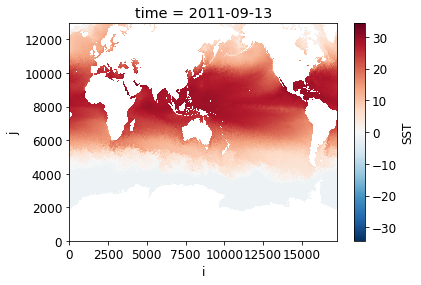

In [51]:
ds.SST.isel(time=0).plot()

In [10]:
coords = cat.LLC4320_grid.to_dask().reset_coords()
coords = llcreader.llcmodel.faces_dataset_to_latlon(coords)

## Make some maps of properties

In [11]:
# Select region 

sel_atl = np.logical_and(np.logical_and(coords.XC>-80, coords.XC<0 ), 
                           np.logical_and(coords.YC>12, coords.YC<50 ))

In [12]:
coords_atl = xr.merge([coords['YC'].where(sel_atl, drop=True), 
                      coords['XC'].where(sel_atl, drop=True)])

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


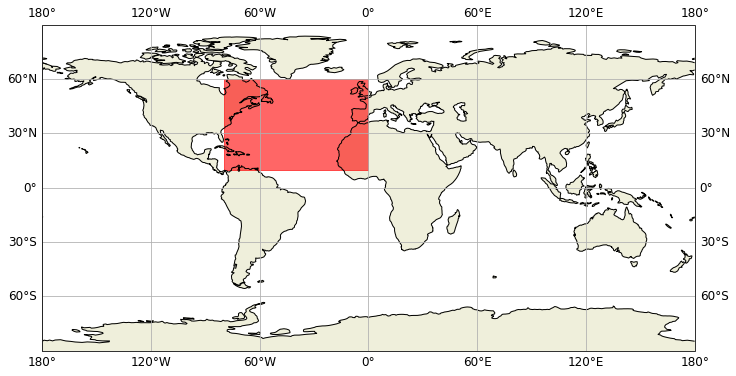

In [14]:
# map of the region
#x_east, y_east = [160, 170, 170, 160, 160], [-60, -60, 60, 60, -60]
#x_west, y_west = [-155, -145, -145, -155, -155], [-60, -60, 60, 60, -60]
#x_atl_east, y_atl_east = [-30, -20, -20, -30, -30], [-60, -60, 60, 60, -60]
#x_atl_west, y_atl_west = [-65, -55, -55, -65, -65], [-60, -60, 60, 60, -60]

x_atl, y_atl = [-80, 0, 0, -80, -80], [10, 10, 60, 60, 10]

#x_sogos, y_sogos = [28, 40, 40, 28, 28], [-56, -56, -48, -48, -48]

plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

ax.fill(x_atl, y_atl, color='red', transform=ccrs.PlateCarree(), alpha=0.6)


ax.coastlines()
ax.set_boundary
ax.add_feature(cfeature.LAND)
ax.gridlines(draw_labels=True);

In [15]:
SST_sel = ds.SST.where(sel_atl, drop=True)
SSS_sel = ds.SSS.where(sel_atl, drop=True)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(sl

In [16]:
SSS_sel

<xarray.DataArray 'SSS' (time: 9030, j: 2378, i: 3840)>
dask.array<where, shape=(9030, 2378, 3840), dtype=float32, chunksize=(1, 2285, 2016), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 8547 8548 8549 8550 8551 ... 10921 10922 10923 10924
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00

In [17]:
from fastjmd95 import rho
ds['SSD'] = xr.apply_ufunc(rho, 
                        ds.SSS, ds.SST, 0, 
                        dask='parallelized', output_dtypes=[float,]).rename('SSD')

In [18]:
ds

,Array,Chunk
Bytes,7.36 TiB,71.19 MiB
Shape,"(9030, 12960, 17280)","(1, 4320, 4320)"
Count,659191 Tasks,108360 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.36 TiB,71.19 MiB
Shape,"(9030, 12960, 17280)","(1, 4320, 4320)"
Count,659191 Tasks,108360 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [19]:
SSD_sel = ds.SSD.where(sel_atl, drop=True)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [20]:
import xgcm
grid = xgcm.Grid(coords.drop(['k', 'k_p1']), periodic=None)

In [21]:
U_sel = (grid.interp(ds.U, 'X', boundary='extend')).where(sel_atl, drop=True).rename('U')
V_sel = (grid.interp(ds.V, 'Y', boundary='extend')).where(sel_atl, drop=True).rename('V')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(sl

In [22]:
U_sel

<xarray.DataArray 'U' (time: 9030, j: 2378, i: 3840)>
dask.array<where, shape=(9030, 2378, 3840), dtype=float32, chunksize=(1, 2285, 2016), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 8547 8548 8549 8550 8551 ... 10921 10922 10923 10924
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00

In [23]:
XC_sel = coords.XC.where(sel_atl, drop=True)
YC_sel = coords.YC.where(sel_atl, drop=True)

In [24]:
sel_atl_z = np.logical_and(np.logical_and(coords.XG>-80, coords.XG<0 ), 
                           np.logical_and(coords.YG>12, coords.YG<50 ))

In [25]:
sel_atl_s = np.logical_and(np.logical_and(coords.XC>-80, coords.XC<0 ), 
                           np.logical_and(coords.YG>12, coords.YG<50 ))
sel_atl_w = np.logical_and(np.logical_and(coords.XG>-80, coords.XG<0 ), 
                           np.logical_and(coords.YC>12, coords.YC<50 ))

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/core.py:4697: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/core.py:4697: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(


In [26]:
sel_atl_s 

<xarray.DataArray 'XC' (j: 12960, i: 17280, j_g: 12960, i_g: 17280)>
dask.array<logical_and, shape=(12960, 17280, 12960, 17280), dtype=bool, chunksize=(4320, 4320, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959

In [27]:
XG_sel = coords.XG.where(sel_atl_z, drop=True)
YG_sel = coords.YG.where(sel_atl_z, drop=True)

In [28]:
rAz_sel = coords.rAz.where(sel_atl_z, drop=True)

In [29]:
coords

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, i_g: 17280, j: 12960, j_g: 12960, k_p1: 2,
              time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * k_p1     (k_p1) int64 0 1
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables: (12/30)
    CS       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    PHrefC   float32 15.4
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    ...       ...
    rAw      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>

In [30]:
zeta =   (-grid.diff(ds.U * coords.dxC, 'Y', boundary='extend') +
             grid.diff(ds.V * coords.dyC, 'X', boundary='extend')
         )/coords.rAz

zeta = grid.interp(grid.interp(zeta, 'X', boundary='extend'),
                   'Y', boundary='extend')

In [31]:
ocean_mask = coords.hFacC.reset_coords(drop=True)>0

In [32]:
zeta_sel = (zeta.where(ocean_mask)).where(sel_atl, drop=True).rename('vort')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [33]:
zeta_sel

<xarray.DataArray 'vort' (time: 9030, j: 2378, i: 3840)>
dask.array<where, shape=(9030, 2378, 3840), dtype=float32, chunksize=(1, 2284, 2016), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 8547 8548 8549 8550 8551 ... 10921 10922 10923 10924
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00

In [34]:
Xmean = coords_atl.XC.isel(i=slice(0,None,10), j=slice(0, None, 10)).mean('j')
Ymean = coords_atl.YC.isel(i=slice(0,None,10), j=slice(0, None, 10)).mean('i')

In [35]:
zeta_sel_coarse = zeta_sel.isel(time=0, i=slice(0,None,10), j=slice(0, None, 10))
zeta_sel_coarse.load()

<xarray.DataArray 'vort' (j: 238, i: 384)>
array([[ 1.1895780e-06, -7.1307619e-07, -5.1459028e-06, ...,
         2.1043963e-05,  4.0097570e-05, -6.2607200e-05],
       [ 1.9576198e-06,  5.9541153e-06,  2.1091637e-06, ...,
         1.7027276e-05, -9.3509916e-06, -4.7221179e-06],
       [-5.5951905e-06,  5.0217122e-06,  1.4487992e-07, ...,
         1.0708002e-05,  5.9523383e-05, -8.5145612e-06],
       ...,
       [-2.0444470e-05, -4.9914211e-06, -1.5937036e-05, ...,
        -9.2474960e-07, -1.9016068e-05, -1.5008072e-05],
       [ 2.4223933e-05,  1.1924203e-05,  8.9936539e-06, ...,
         6.5563449e-07,  1.8104736e-06, -4.3353034e-06],
       [-1.0008137e-05,  7.8236972e-06,  9.7221846e-06, ...,
        -3.0214296e-06,  4.9036189e-06, -1.3668849e-05]], dtype=float32)
Coordinates:
  * i        (i) int64 0 10 20 30 40 50 ... 17220 17230 17240 17250 17260 17270
  * j        (j) int64 8547 8557 8567 8577 8587 ... 10887 10897 10907 10917
    time     datetime64[ns] 2011-09-13

/tmp/ipykernel_454/1581871726.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(Xmean, Ymean, zeta_sel_coarse,


(30.0, 40.0)

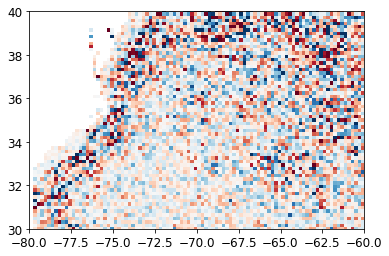

In [36]:
plt.pcolormesh(Xmean, Ymean, zeta_sel_coarse, 
               vmin=-5e-5, vmax=5e-5, cmap='RdBu_r')
plt.xlim([-80, -60])
plt.ylim([30, 40])

In [37]:
zeta_sel = zeta.where(sel_atl, drop=True).rename('vort')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [38]:
bx = (grid.interp(grid.diff(ds.SSD, 'X', boundary='extend')/coords.dxC, 
                    'X', boundary='extend'))
by = (grid.interp(grid.diff(ds.SSD, 'Y', boundary='extend')/coords.dyC, 
                    'Y', boundary='extend'))      

In [39]:
Tx = (grid.interp(grid.diff(ds.SST, 'X', boundary='extend')/coords.dxC, 
                    'X', boundary='extend'))
Ty = (grid.interp(grid.diff(ds.SST, 'Y', boundary='extend')/coords.dyC, 
                    'Y', boundary='extend'))      

In [40]:
bx_sel = bx.where(sel_atl, drop=True).rename('bx')
by_sel = by.where(sel_atl, drop=True).rename('by')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(sl

In [41]:
Tx_sel = Tx.where(sel_atl, drop=True).rename('Tx')
Ty_sel = Ty.where(sel_atl, drop=True).rename('Ty')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(sl

In [42]:
gradB_sel = np.abs(bx_sel) + np.abs(by_sel)

In [52]:
gradT_sel = np.abs(Tx_sel) + np.abs(Ty_sel)

### Things to consider/do
- Time series of buoyancy
- Maps of buoyancy
- Spectra of buoyancy (spatial)
- Time series of "small-scale" variance (choose some cutoff)

### Time series and maps

In [53]:
SSD_sel_10day_coarse = SSD_sel.isel(time=slice(0,24*370,24*10),
                            i = slice(0,None, 4), 
                            j = slice(0,None, 4) )

In [54]:
coords_atl_coarse = coords_atl.isel(i = slice(0,None, 4), 
                                    j = slice(0,None, 4) )

In [55]:
Xcoarse =coords_atl_coarse.XC.mean('j')
Ycoarse =coords_atl_coarse.YC.mean('i')

In [56]:
Xatl =coords_atl.XC.mean('j')
Yatl =coords_atl.YC.mean('i')

In [57]:
Xatl

<xarray.DataArray 'XC' (i: 3840)>
dask.array<mean_agg-aggregate, shape=(3840,), dtype=float32, chunksize=(2016,), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279

In [58]:
Xcoarse

<xarray.DataArray 'XC' (i: 960)>
dask.array<mean_agg-aggregate, shape=(960,), dtype=float32, chunksize=(504,), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 0 4 8 12 16 20 24 ... 17256 17260 17264 17268 17272 17276

### Maps of large scale quantities in different seasons

In [59]:
SSD_winter = SSD_sel.sel(time="2012-02-15T00:00:00").isel(
                            i = slice(0,None, 4), 
                            j = slice(0,None, 4) )
SSD_winter.load()
SSD_summer = SSD_sel.sel(time="2012-08-15T00:00:00").isel(
                            i = slice(0,None, 4), 
                            j = slice(0,None, 4) )
SSD_summer.load();

In [60]:
%%time
SST_winter = SST_sel.sel(time="2012-02-15T00:00:00").isel(
                            i = slice(0,None, 4), 
                            j = slice(0,None, 4) )
SST_winter.load()
SST_summer = SST_sel.sel(time="2012-08-15T00:00:00").isel(
                            i = slice(0,None, 4), 
                            j = slice(0,None, 4) )
SST_summer.load();

CPU times: user 5.03 s, sys: 1.29 s, total: 6.32 s
Wall time: 2.17 s


<xarray.DataArray 'SST' (j: 595, i: 960)>
array([[27.775764, 27.81671 , 27.863743, ..., 27.671686, 27.73621 ,
        27.772392],
       [27.74948 , 27.814129, 27.866007, ..., 27.706121, 27.722475,
        27.757586],
       [27.81307 , 27.812336, 27.87315 , ..., 27.71558 , 27.665083,
        27.762877],
       ...,
       [13.838551, 14.218953, 14.385054, ..., 15.488382, 15.401895,
        15.294643],
       [14.32539 , 14.334982, 14.40987 , ..., 15.400314, 14.394658,
        14.029619],
       [14.297022, 14.397592, 14.452675, ..., 13.908026, 14.269921,
        14.239976]], dtype=float32)
Coordinates:
  * i        (i) int64 0 4 8 12 16 20 24 ... 17256 17260 17264 17268 17272 17276
  * j        (j) int64 8547 8551 8555 8559 8563 ... 10911 10915 10919 10923
    time     datetime64[ns] 2012-08-15

In [61]:
U_winter = U_sel.sel(time="2012-02-15T00:00:00").isel(
                            i = slice(0,None, 4), 
                            j = slice(0,None, 4) )
U_winter.load()
V_winter = V_sel.sel(time="2012-02-15T00:00:00").isel(
                            i = slice(0,None, 4), 
                            j = slice(0,None, 4) )
V_winter.load()

U_summer = U_sel.sel(time="2012-08-15T00:00:00").isel(
                            i = slice(0,None, 4), 
                            j = slice(0,None, 4) )
U_summer.load()
V_summer = V_sel.sel(time="2012-08-15T00:00:00").isel(
                            i = slice(0,None, 4), 
                            j = slice(0,None, 4) )
V_summer.load();

In [62]:
KE_summer = 0.5*(np.abs(U_summer) + np.abs(V_summer))
KE_winter = 0.5*(np.abs(U_winter) + np.abs(V_winter))

In [63]:
Xatl

<xarray.DataArray 'XC' (i: 3840)>
dask.array<mean_agg-aggregate, shape=(3840,), dtype=float32, chunksize=(2016,), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279

In [64]:
Yatl

<xarray.DataArray 'YC' (j: 2378)>
dask.array<mean_agg-aggregate, shape=(2378,), dtype=float32, chunksize=(2285,), chunktype=numpy.ndarray>
Coordinates:
  * j        (j) int64 8547 8548 8549 8550 8551 ... 10921 10922 10923 10924

In [65]:
SSD_summer

<xarray.DataArray 'SSD' (j: 595, i: 960)>
array([[1022.91792114, 1022.89501411, 1022.86499392, ..., 1022.98863433,
        1022.9567579 , 1022.93239195],
       [1022.91746984, 1022.8837991 , 1022.85807229, ..., 1022.98414932,
        1022.95989598, 1022.92978199],
       [1022.89445536, 1022.88377793, 1022.85783307, ..., 1022.97760066,
        1022.97307867, 1022.92685599],
       ...,
       [1024.75974907, 1024.86799164, 1024.86009678, ..., 1024.39278785,
        1024.37033338, 1024.41369172],
       [1024.86609874, 1024.83557553, 1024.84557327, ..., 1024.3752171 ,
        1024.61567179, 1024.83398032],
       [1024.83431279, 1024.85397978, 1024.85476537, ..., 1024.80712936,
        1024.87686482, 1024.8259547 ]])
Coordinates:
  * i        (i) int64 0 4 8 12 16 20 24 ... 17256 17260 17264 17268 17272 17276
  * j        (j) int64 8547 8551 8555 8559 8563 ... 10911 10915 10919 10923
    time     datetime64[ns] 2012-08-15

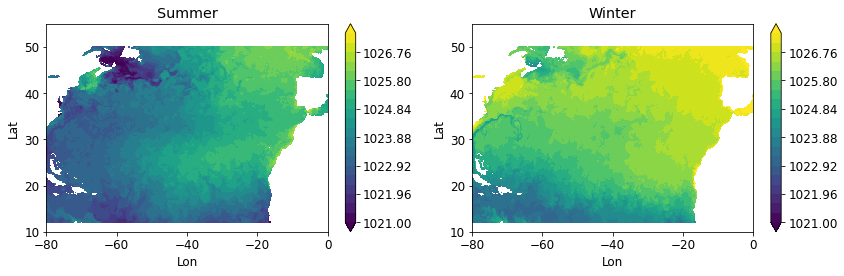

In [66]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contourf(Xcoarse, Ycoarse, SSD_summer, vmin=1021, vmax=1027.4,
             levels=np.linspace(1021.,1027.4,21), extend='both')
plt.title('Summer')
plt.xlim([-80, 0])
plt.ylim([10, 55])
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.colorbar()

plt.subplot(122)
plt.contourf(Xcoarse, Ycoarse, SSD_winter, vmin=1021, vmax=1027.4,
             levels=np.linspace(1021.,1027.4,21), extend='both')
plt.title('Winter')
plt.xlim([-80, 0])
plt.ylim([10, 55])
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.colorbar()
plt.tight_layout()

plt.savefig('natl_SSD.png')

In [67]:
SST_summer

<xarray.DataArray 'SST' (j: 595, i: 960)>
array([[27.775764, 27.81671 , 27.863743, ..., 27.671686, 27.73621 ,
        27.772392],
       [27.74948 , 27.814129, 27.866007, ..., 27.706121, 27.722475,
        27.757586],
       [27.81307 , 27.812336, 27.87315 , ..., 27.71558 , 27.665083,
        27.762877],
       ...,
       [13.838551, 14.218953, 14.385054, ..., 15.488382, 15.401895,
        15.294643],
       [14.32539 , 14.334982, 14.40987 , ..., 15.400314, 14.394658,
        14.029619],
       [14.297022, 14.397592, 14.452675, ..., 13.908026, 14.269921,
        14.239976]], dtype=float32)
Coordinates:
  * i        (i) int64 0 4 8 12 16 20 24 ... 17256 17260 17264 17268 17272 17276
  * j        (j) int64 8547 8551 8555 8559 8563 ... 10911 10915 10919 10923
    time     datetime64[ns] 2012-08-15

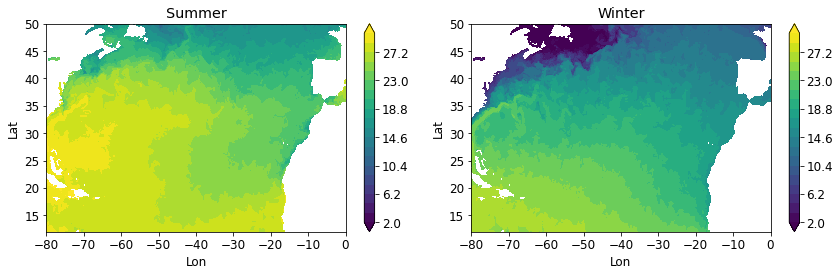

In [68]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contourf(Xcoarse, Ycoarse, SST_summer, vmin=2, vmax=30,
             levels=np.linspace(2.,30,21), extend='both')
plt.title('Summer')
plt.xlim([-80, 0])
plt.ylim([12, 50])
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.colorbar()

plt.subplot(122)
plt.contourf(Xcoarse, Ycoarse, SST_winter, vmin=2, vmax=30,
             levels=np.linspace(2.,30,21), extend='both')
plt.title('Winter')
plt.xlim([-80, 0])
plt.ylim([12, 50])
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.colorbar()

plt.tight_layout()

plt.savefig('natl_SST.png')

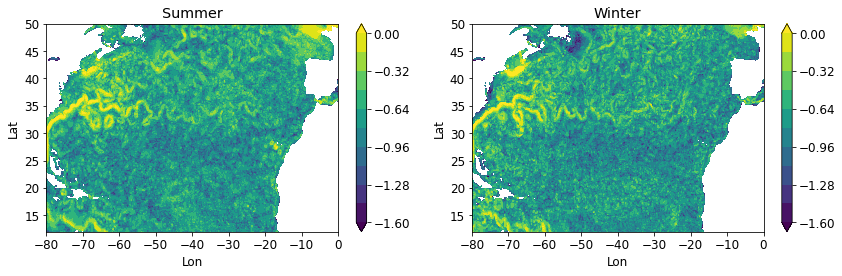

In [69]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contourf(Xcoarse, Ycoarse, np.log10(KE_summer), levels=np.linspace(-1.6,0,11), extend='both')
plt.title('Summer')
plt.xlim([-80, 0])
plt.ylim([12, 50])
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.colorbar()

plt.subplot(122)
plt.contourf(Xcoarse, Ycoarse, np.log10(KE_winter), levels=np.linspace(-1.6,0,11), extend='both')
plt.title('Winter')
plt.xlim([-80, 0])
plt.ylim([12, 50])
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.colorbar()

plt.tight_layout()

plt.savefig('natl_speed.png')

### Maps of gradient quantities

In [70]:
%%time
zeta_winter = zeta_sel.sel(time="2012-02-15T00:00:00")
zeta_winter.load()
zeta_summer = zeta_sel.sel(time="2012-08-15T00:00:00")
zeta_summer.load();

CPU times: user 33.4 s, sys: 10.9 s, total: 44.3 s
Wall time: 17.9 s


<xarray.DataArray 'vort' (j: 2378, i: 3840)>
array([[ 1.0333999e-05,  3.8723970e-06,  1.9807171e-06, ...,
         1.1564314e-05,  3.6094311e-06,  3.9919541e-08],
       [ 7.3222504e-06,  1.4882867e-06,  3.6241570e-07, ...,
         3.8462676e-05,  3.3228862e-05,  3.1663883e-05],
       [ 6.6150624e-06,  3.7230834e-07, -2.3608453e-07, ...,
         5.5947086e-05,  4.8003501e-05,  4.3760876e-05],
       ...,
       [ 1.5206501e-05,  1.8659819e-05,  1.8118479e-05, ...,
        -1.2746900e-05,  1.3102029e-05,  2.5710044e-05],
       [ 1.9057668e-05,  2.3420387e-05,  2.1446964e-05, ...,
        -3.8655517e-06,  1.5487203e-05,  2.2066259e-05],
       [ 2.0122454e-05,  2.2295018e-05,  1.9597021e-05, ...,
         1.0726810e-06,  1.7512957e-05,  2.2813638e-05]], dtype=float32)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 8547 8548 8549 8550 8551 ... 10921 10922 10923 10924
    time     datetime64[ns] 2012-08-15

In [71]:
%%time
f = 2 * 2*np.pi/24/3600 * np.sin(Yatl*np.pi/180)
f.load()

CPU times: user 1.56 s, sys: 469 ms, total: 2.03 s
Wall time: 461 ms


<xarray.DataArray 'YC' (j: 2378)>
array([3.0255494e-05, 3.0302132e-05, 3.0348765e-05, ..., 1.1135549e-04,
       1.1137611e-04, 1.1139673e-04], dtype=float32)
Coordinates:
  * j        (j) int64 8547 8548 8549 8550 8551 ... 10921 10922 10923 10924

In [72]:
zeta_winter

<xarray.DataArray 'vort' (j: 2378, i: 3840)>
array([[ 4.5780776e-06, -8.6573027e-07, -1.2958876e-06, ...,
        -5.0398412e-05, -4.2209533e-05, -3.9419254e-05],
       [ 7.8363319e-06,  2.3673063e-06,  7.6886829e-07, ...,
        -5.1780917e-05, -3.7074678e-05, -3.1334086e-05],
       [ 7.9532601e-06,  1.6410831e-06,  6.9762166e-08, ...,
        -2.3176304e-05, -2.0959149e-05, -2.3909373e-05],
       ...,
       [-7.7067025e-06, -2.9104502e-05, -3.4410776e-05, ...,
        -2.6024078e-05, -3.4527471e-05, -2.9945910e-05],
       [ 4.2734100e-06, -2.4690347e-05, -5.0786693e-05, ...,
        -7.8931589e-06, -3.2433487e-05, -4.2714506e-05],
       [ 1.8246534e-05, -4.2276756e-06, -4.6571320e-05, ...,
         1.4852648e-05, -1.6040223e-05, -3.8831797e-05]], dtype=float32)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 8547 8548 8549 8550 8551 ... 10921 10922 10923 10924
    time     datetime64[ns] 2012-02-15

/tmp/ipykernel_454/1172447591.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(Xatl, Yatl, zeta_winter, vmin=-1e-4, vmax=1e-4, cmap='RdBu_r')


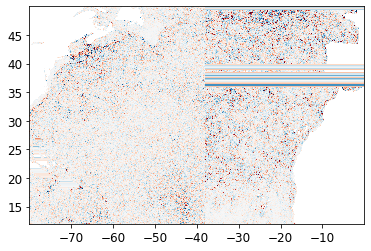

In [73]:
plt.pcolormesh(Xatl, Yatl, zeta_winter, vmin=-1e-4, vmax=1e-4, cmap='RdBu_r')

/tmp/ipykernel_454/2490344132.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(Xatl, Yatl, zeta_summer, vmin=-1e-4, vmax=1e-4, cmap='RdBu_r')


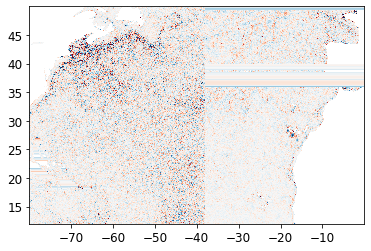

In [74]:
plt.pcolormesh(Xatl, Yatl, zeta_summer, vmin=-1e-4, vmax=1e-4, cmap='RdBu_r')

### Spectra Spatial Tracers

In [75]:
import xrft

In [76]:
SSD_sel_10day_coarse.time.isel(time=0)

<xarray.DataArray 'time' ()>
array('2011-09-13T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2011-09-13

/tmp/ipykernel_454/3651474253.py:8: UserWarning: The following kwargs were not used by contour: 'rasterized'
  plt.contourf(Xcoarse, Ycoarse, SSD_sel_10day_coarse.isel(time=0),


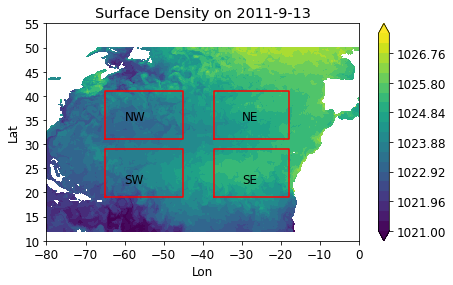

In [77]:
# define 4 regions
xreg1, yreg1 = [-65, -45, -45, -65, -65], [19, 19, 29, 29, 19]
xreg2, yreg2 = [-65, -45, -45, -65, -65], [31, 31, 41, 41, 31]
xreg3, yreg3 = [-37, -18, -18, -37, -37], [19, 19, 29, 29, 19]
xreg4, yreg4 = [-37, -18, -18, -37, -37], [31, 31, 41, 41, 31]

plt.figure(figsize=(7,4))
plt.contourf(Xcoarse, Ycoarse, SSD_sel_10day_coarse.isel(time=0),
            levels=np.linspace(1021.,1027.4,21), extend='both',
            rasterized=True)
plt.plot(xreg1, yreg1, color='r')
plt.text(-60, 22, 'SW')
plt.plot(xreg2, yreg2, color='r')
plt.text(-60, 35, 'NW')
plt.plot(xreg3, yreg3, color='r')
plt.text(-30, 22, 'SE')
plt.plot(xreg4, yreg4, color='r')
plt.text(-30, 35, 'NE')
plt.xlim([-80, 0])
plt.ylim([10, 55])
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.colorbar()
plt.title('Surface Density on 2011-9-13')
plt.savefig('natl_map.png')

In [78]:
sel_SW = np.logical_and(np.logical_and(coords.XC>-65, coords.XC<-45 ),
                           np.logical_and(coords.YC>19, coords.YC<29))
sel_NW = np.logical_and(np.logical_and(coords.XC>-65, coords.XC<-45 ),
                           np.logical_and(coords.YC>31, coords.YC<41))
sel_SE = np.logical_and(np.logical_and(coords.XC>-37.5, coords.XC<-18.5 ),
                           np.logical_and(coords.YC>19, coords.YC<29))
sel_NE = np.logical_and(np.logical_and(coords.XC>-37.5, coords.XC<-18.5 ),
                           np.logical_and(coords.YC>31, coords.YC<41))

In [79]:
SSD_SE = SSD_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SE, drop=True)
SSD_NE = SSD_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NE, drop=True)
SSD_SW = SSD_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SW, drop=True)
SSD_NW = SSD_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NW, drop=True)

In [80]:
SSS_SE = SSS_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SE, drop=True)
SSS_NE = SSS_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NE, drop=True)
SSS_SW = SSS_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SW, drop=True)
SSS_NW = SSS_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NW, drop=True)

In [81]:
SST_SE = SST_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SE, drop=True)
SST_NE = SST_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NE, drop=True)
SST_SW = SST_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SW, drop=True)
SST_NW = SST_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NW, drop=True)

In [82]:
SST_SE_TS = SST_SE.isel(i=slice(0, None, 10), 
            time=slice(0,None,3)).mean(['i','j'])
SST_SE_TS.load()

SST_SW_TS = SST_SW.isel(i=slice(0, None, 10), 
            time=slice(0,None,3)).mean(['i','j'])
SST_SW_TS.load()

SST_NE_TS = SST_NE.isel(i=slice(0, None, 10), 
            time=slice(0,None,3)).mean(['i','j'])
SST_NE_TS.load()

SST_NW_TS = SST_NW.isel(i=slice(0, None, 10), 
            time=slice(0,None,3)).mean(['i','j'])
SST_NW_TS.load()

<xarray.DataArray 'SST' (time: 13)>
array([26.078054, 23.672562, 21.56707 , 20.258966, 18.957764, 18.063616,
       17.670378, 17.808977, 18.793772, 21.163124, 24.048101, 26.578028,
       26.309412], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 2011-10-13 ... 2012-09-07

In [83]:
%%time
SSD_SE_TS = SSD_SE.isel(i=slice(0, None, 10), 
            time=slice(0,None,3)).mean(['i','j'])
SSD_SE_TS.load()

SSD_SW_TS = SSD_SW.isel(i=slice(0, None, 10), 
            time=slice(0,None,3)).mean(['i','j'])
SSD_SW_TS.load()

SSD_NE_TS = SSD_NE.isel(i=slice(0, None, 10), 
            time=slice(0,None,3)).mean(['i','j'])
SSD_NE_TS.load()

SSD_NW_TS = SSD_NW.isel(i=slice(0, None, 10), 
            time=slice(0,None,3)).mean(['i','j'])
SSD_NW_TS.load()

CPU times: user 55.5 s, sys: 10.8 s, total: 1min 6s
Wall time: 14.7 s


<xarray.DataArray 'SSD' (time: 13)>
array([1023.40754271, 1024.24738128, 1024.92746357, 1025.35305861,
       1025.73777941, 1026.01246391, 1026.1350049 , 1026.06773878,
       1025.8622741 , 1025.1344969 , 1024.28035207, 1023.39280451,
       1023.43778453])
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 2011-10-13 ... 2012-09-07

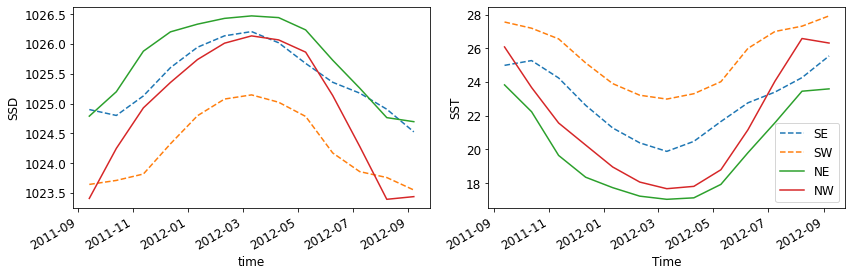

In [84]:
plt.figure(figsize=(12,4))

plt.subplot(121)
SSD_SE_TS.plot(linestyle='--',label='SE')
SSD_SW_TS.plot(linestyle='--',label='SW')
SSD_NE_TS.plot(label='NE')
SSD_NW_TS.plot(label='NW')


plt.subplot(122)
SST_SE_TS.plot(linestyle='--',label='SE')
SST_SW_TS.plot(linestyle='--',label='SW')
SST_NE_TS.plot(label='NE')
SST_NW_TS.plot(label='NW')
plt.legend()

plt.tight_layout()

plt.savefig('seasonal_time_series.png')

In [85]:
%%time
coords_SW = xr.merge([coords.XC.where(sel_SW, drop=True),
                      coords.YC.where(sel_SW, drop=True)])


CPU times: user 11.3 s, sys: 3.07 s, total: 14.4 s
Wall time: 3.67 s


In [86]:
%%time
coords_SE = xr.merge([coords.XC.where(sel_SE, drop=True),
                      coords.YC.where(sel_SE, drop=True)])


CPU times: user 11 s, sys: 2.91 s, total: 14 s
Wall time: 3.58 s


In [87]:
%%time
coords_NW = xr.merge([coords.XC.where(sel_NW, drop=True),
                      coords.YC.where(sel_NW, drop=True)])

CPU times: user 11.1 s, sys: 2.84 s, total: 14 s
Wall time: 3.65 s


In [88]:
%%time
coords_NE = xr.merge([coords.XC.where(sel_NE, drop=True),
                      coords.YC.where(sel_NE, drop=True)])

CPU times: user 11.3 s, sys: 2.96 s, total: 14.3 s
Wall time: 3.65 s


In [89]:
dxNW = 110*(coords_NW.XC.isel(i=1) - coords_NW.XC.isel(i=0))*np.cos(coords_NW.YC.mean('i')*np.pi/180)
dxNE = 110*(coords_NE.XC.isel(i=1) - coords_NE.XC.isel(i=0))*np.cos(coords_NE.YC.mean('i')*np.pi/180)

dxSW = 110*(coords_SW.XC.isel(i=1) - coords_SW.XC.isel(i=0))*np.cos(coords_SW.YC.mean('i')*np.pi/180)
dxSE = 110*(coords_SE.XC.isel(i=1) - coords_SE.XC.isel(i=0))*np.cos(coords_SE.YC.mean('i')*np.pi/180)

In [90]:
SSD_SE_k_ps = xrft.power_spectrum(SSD_SE, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('SSD_SE_psd')
SSD_SW_k_ps = xrft.power_spectrum(SSD_SW, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('SSD_SW_psd')
SSD_NE_k_ps = xrft.power_spectrum(SSD_NE, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('SSD_NE_psd')
SSD_NW_k_ps = xrft.power_spectrum(SSD_NW, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('SSD_NW_psd')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


In [91]:
SST_SE_k_ps = xrft.power_spectrum(SST_SE, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('SSD_SE_psd')
SST_SW_k_ps = xrft.power_spectrum(SST_SW, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('SSD_SW_psd')
SST_NE_k_ps = xrft.power_spectrum(SST_NE, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('SSD_NE_psd')
SST_NW_k_ps = xrft.power_spectrum(SST_NW, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('SSD_NW_psd')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


In [92]:
SSD_SE_k_ps.load()
SSD_SW_k_ps.load()
SSD_NE_k_ps.load()
SSD_NW_k_ps.load();

In [93]:
%%time
SST_SE_k_ps.load()
SST_SW_k_ps.load()
SST_NE_k_ps.load()
SST_NW_k_ps.load();

CPU times: user 33.6 s, sys: 7.47 s, total: 41 s
Wall time: 13 s


<xarray.DataArray 'SSD_NW_psd' (time: 37, j: 64, freq_i: 960)>
array([[[2.01762068e-07, 3.12465851e-06, 2.65867277e-07, ...,
         1.17930515e-06, 2.65867277e-07, 3.12465851e-06],
        [8.21834699e-07, 1.98691920e-06, 1.44451693e-06, ...,
         5.38639891e-07, 1.44451693e-06, 1.98691920e-06],
        [2.28496615e-07, 2.33671338e-06, 5.24651143e-07, ...,
         7.57955529e-07, 5.24651143e-07, 2.33671338e-06],
        ...,
        [2.06059252e-06, 5.82424460e-07, 1.48019746e-07, ...,
         5.33793200e-07, 1.48019746e-07, 5.82424460e-07],
        [5.13132808e-08, 1.15527162e-06, 1.30458271e-06, ...,
         6.44512957e-07, 1.30458271e-06, 1.15527162e-06],
        [3.58595179e-06, 7.48408405e-06, 9.42188977e-06, ...,
         1.08438105e-05, 9.42188977e-06, 7.48408405e-06]],

       [[1.08676193e-09, 2.35276521e-07, 2.51272297e-07, ...,
         1.22011591e-08, 2.51272297e-07, 2.35276521e-07],
        [6.09329285e-08, 4.26665071e-07, 7.47548507e-07, ...,
         2.98857613e-07, 7.47548507e-07, 4.26665071e-07],
        [7.61554268e-06, 7.16287314e-06, 7.56318220e-06, ...,
         6.89712488e-06, 7.56318220e-06, 7.16287314e-06],
...
        [6.08983249e-07, 2.37994191e-06, 7.22097673e-06, ...,
         1.38988621e-05, 7.22097673e-06, 2.37994191e-06],
        [5.85862601e-08, 2.80977731e-07, 1.25653340e-06, ...,
         1.20953466e-05, 1.25653340e-06, 2.80977731e-07],
        [1.85959311e-05, 1.17092378e-05, 4.18703616e-06, ...,
         1.29190128e-05, 4.18703616e-06, 1.17092378e-05]],

       [[2.74316648e-07, 3.63237210e-07, 1.97225142e-07, ...,
         3.32682464e-08, 1.97225142e-07, 3.63237210e-07],
        [3.20636318e-06, 1.61704458e-06, 9.64432712e-07, ...,
         1.14293699e-06, 9.64432712e-07, 1.61704458e-06],
        [5.37122959e-07, 8.08116108e-07, 6.71253377e-07, ...,
         3.09985959e-07, 6.71253377e-07, 8.08116108e-07],
        ...,
        [1.01630436e-06, 1.07661363e-06, 5.84464247e-07, ...,
         1.47387871e-06, 5.84464247e-07, 1.07661363e-06],
        [7.69428687e-10, 5.27885576e-07, 1.10734685e-06, ...,
         1.17364219e-07, 1.10734685e-06, 5.27885576e-07],
        [1.74463449e-07, 3.45211091e-07, 6.70802821e-07, ...,
         1.92773434e-07, 6.70802821e-07, 3.45211091e-07]]])
Coordinates:
  * j        (j) int64 9627 9637 9647 9657 9667 ... 10227 10237 10247 10257
  * time     (time) datetime64[ns] 2011-09-13 2011-09-23 ... 2012-09-07
  * freq_i   (freq_i) float64 -0.5 -0.499 -0.4979 ... 0.4969 0.4979 0.499

In [94]:
import warnings
warnings.filterwarnings('ignore')

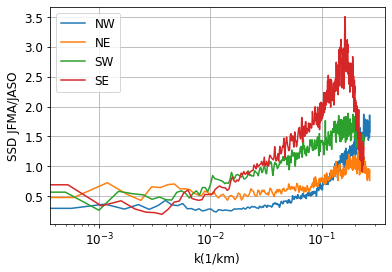

In [96]:
plt.plot(SSD_NW_k_ps.freq_i/dxNE.mean(),
         SSD_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         SSD_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='NW')
plt.plot(SSD_NE_k_ps.freq_i/dxNE.mean(),
         SSD_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         SSD_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='NE')
plt.plot(SSD_SW_k_ps.freq_i/dxSW.mean(),
         SSD_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         SSD_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='SW')
plt.plot(SSD_SE_k_ps.freq_i/dxSE.mean(),
         SSD_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         SSD_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='SE')

plt.xscale('log')
plt.legend()
#plt.ylim([0, 6])
plt.grid()
plt.xlabel('k(1/km)')
plt.ylabel('SSD JFMA/JASO')
plt.savefig('Ratio_SSD.png')

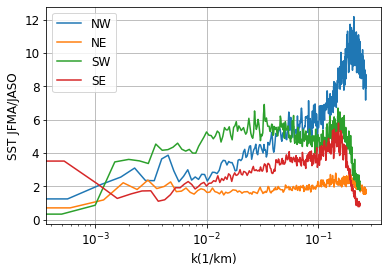

In [97]:
plt.plot(SST_NW_k_ps.freq_i/dxNE.mean(),
         SST_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         SST_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='NW')
plt.plot(SST_NE_k_ps.freq_i/dxNE.mean(),
         SST_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         SST_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='NE')
plt.plot(SST_SW_k_ps.freq_i/dxSW.mean(),
         SST_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         SST_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='SW')
plt.plot(SST_SE_k_ps.freq_i/dxSE.mean(),
         SST_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         SST_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='SE')

plt.xscale('log')
plt.legend()
#plt.ylim([0, 6])
plt.grid()
plt.xlabel('k(1/km)')
plt.ylabel('SST JFMA/JASO')
plt.savefig('Ratio_SST.png')

Text(0.5, 1.0, 'North West')

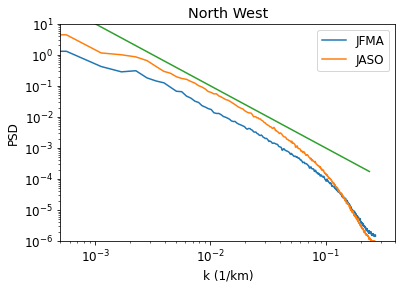

In [98]:
plt.plot(SSD_NW_k_ps.freq_i/dxNE.mean(),
         SSD_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(SSD_NW_k_ps.freq_i/dxNE.mean(),
         SSD_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')
k =SST_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-6, 10])
plt.legend()
plt.title('North West')

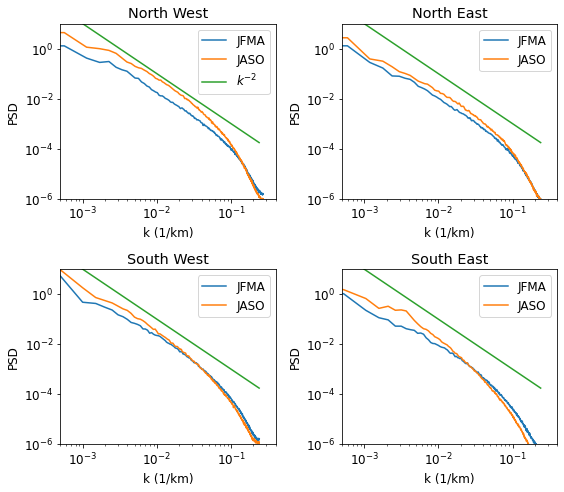

In [100]:
plt.figure(figsize=(8,7))
plt.subplot(221)
plt.plot(SSD_NW_k_ps.freq_i/dxNE.mean(),
         SSD_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(SSD_NW_k_ps.freq_i/dxNE.mean(),
         SSD_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')
k =SSD_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2, label=r'$k^{-2}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-6, 10])
plt.legend()
plt.title('North West')

plt.subplot(222)
plt.plot(SSD_NE_k_ps.freq_i/dxNE.mean(),
         SSD_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(SSD_NE_k_ps.freq_i/dxNE.mean(),
         SSD_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')
k =SSD_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-6, 10])
plt.legend()
plt.title('North East')


plt.subplot(223)
plt.plot(SSD_SW_k_ps.freq_i/dxSW.mean(),
         SSD_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(SSD_SW_k_ps.freq_i/dxSW.mean(),
         SSD_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')
k =SSD_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-6, 10])
plt.legend()
plt.title('South West')

plt.subplot(224)
plt.plot(SSD_SE_k_ps.freq_i/dxSE.mean(),
         SSD_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(SSD_SE_k_ps.freq_i/dxSE.mean(),
         SSD_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')

k =SSD_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-6, 10])
plt.legend()
plt.title('South East')

plt.tight_layout()

plt.savefig('Spectra_SSD.png')

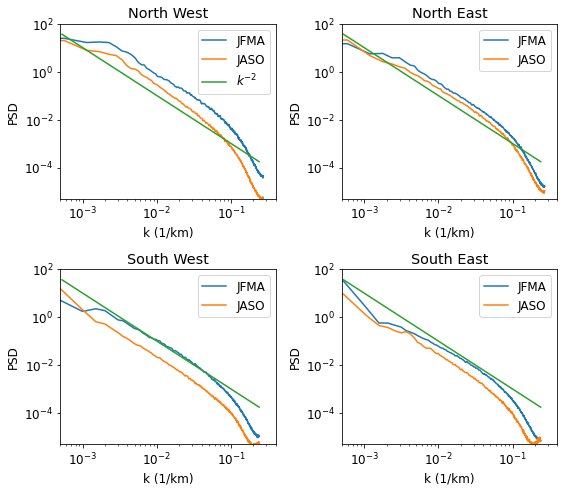

In [101]:
plt.figure(figsize=(8,7))
plt.subplot(221)
plt.plot(SST_NW_k_ps.freq_i/dxNE.mean(),
         SST_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')

plt.plot(SST_NW_k_ps.freq_i/dxNE.mean(),
         SST_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')
k =SST_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2, label=r'$k^{-2}$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([5e-6, 100])
plt.legend()
plt.title('North West')

plt.subplot(222)
plt.plot(SST_NE_k_ps.freq_i/dxNE.mean(),
         SST_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(SST_NE_k_ps.freq_i/dxNE.mean(),
         SST_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')
k =SST_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([5e-6, 100])
plt.legend()
plt.title('North East')


plt.subplot(223)
plt.plot(SST_SW_k_ps.freq_i/dxSW.mean(),
         SST_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(SST_SW_k_ps.freq_i/dxSW.mean(),
         SST_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')
k =SST_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([5e-6, 100])
plt.legend()
plt.title('South West')

plt.subplot(224)
plt.plot(SST_SE_k_ps.freq_i/dxSE.mean(),
         SST_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(SST_SE_k_ps.freq_i/dxSE.mean(),
         SST_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')

k =SST_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([5e-6, 100])
plt.legend()
plt.title('South East')

plt.tight_layout()

plt.savefig('Spectra_SST.png')

Text(0.5, 1.0, 'South East')

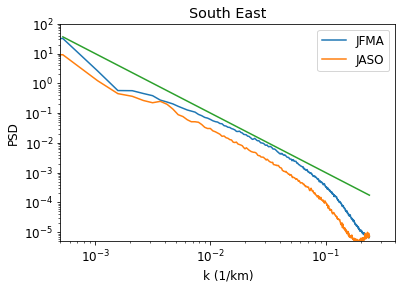

In [102]:
plt.plot(SST_SE_k_ps.freq_i/dxSE.mean(),
         SST_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(SST_SE_k_ps.freq_i/dxSE.mean(),
         SST_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')

k =SST_SE_k_ps.freq_i/dxSE.mean();
plt.plot(k, 1e-5*k**-2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([5e-6, 100])
plt.legend()
plt.title('South East')

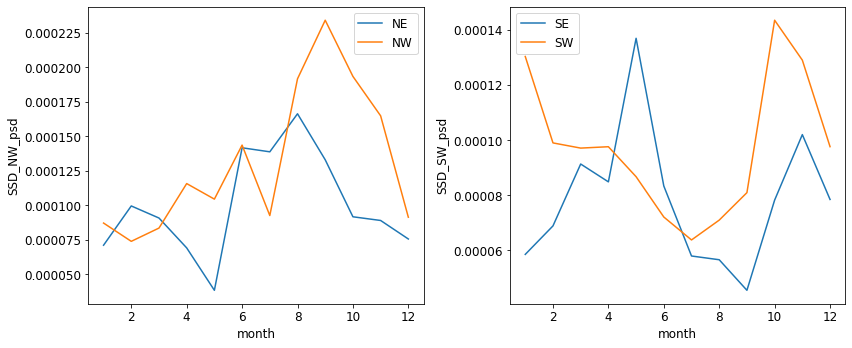

In [103]:
plt.figure(figsize=(12,5))
plt.subplot(121)
SSD_NE_k_ps.mean('j').isel(freq_i=slice(0,400)
                          ).mean('freq_i').groupby("time.month").mean().plot(label='NE')
SSD_NW_k_ps.mean('j').isel(freq_i=slice(0,400)
                          ).mean('freq_i').groupby("time.month").mean().plot(label='NW')
plt.legend()

plt.subplot(122)
SSD_SE_k_ps.mean('j').isel(freq_i=slice(0,400)
                          ).mean('freq_i').groupby("time.month").mean().plot(label='SE')
SSD_SW_k_ps.mean('j').isel(freq_i=slice(0,400)
                          ).mean('freq_i').groupby("time.month").mean().plot(label='SW')

plt.legend()

plt.tight_layout()

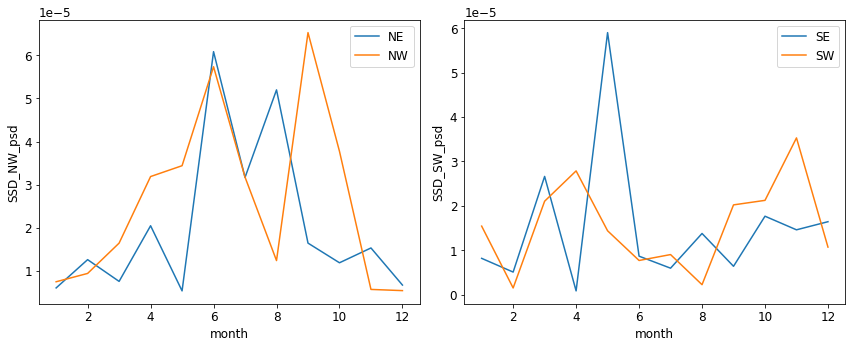

In [104]:
plt.figure(figsize=(12,5))
plt.subplot(121)
SSD_NE_k_ps.mean('j').isel(freq_i=slice(0,400)
                          ).mean('freq_i').groupby("time.month").std().plot(label='NE')
SSD_NW_k_ps.mean('j').isel(freq_i=slice(0,400)
                          ).mean('freq_i').groupby("time.month").std().plot(label='NW')
plt.legend()

plt.subplot(122)
SSD_SE_k_ps.mean('j').isel(freq_i=slice(0,400)
                          ).mean('freq_i').groupby("time.month").std().plot(label='SE')
SSD_SW_k_ps.mean('j').isel(freq_i=slice(0,400)
                          ).mean('freq_i').groupby("time.month").std().plot(label='SW')

plt.legend()

plt.tight_layout()

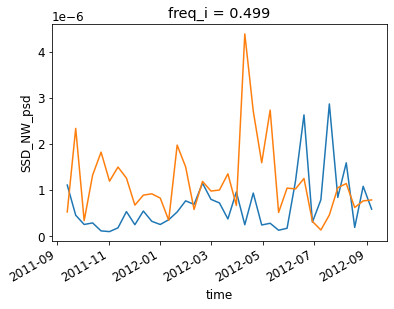

In [105]:
SSD_NE_k_ps.mean('j').isel(freq_i=-1).plot()
SSD_NW_k_ps.mean('j').isel(freq_i=-1).plot()
#SST_SE_k_ps.mean('j').isel(freq_i=-1).plot()
#SST_SW_k_ps.mean('j').isel(freq_i=-1).plot()

### Spectra Spatial Surface Velocity

In [106]:
U_SE = U_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SE, drop=True)
U_NE = U_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NE, drop=True)
U_SW = U_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SW, drop=True)
U_NW = U_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NW, drop=True)

In [107]:
V_SE = V_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SE, drop=True)
V_NE = V_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NE, drop=True)
V_SW = V_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_SW, drop=True)
V_NW = V_sel.isel(time=slice(0,24*370,24*10),
                        j=slice(0,None,10)).where(sel_NW, drop=True)

In [108]:
U_SE_k_ps = xrft.power_spectrum(U_SE, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('U_SE_psd')
U_SW_k_ps = xrft.power_spectrum(U_SW, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('U_SW_psd')
U_NE_k_ps = xrft.power_spectrum(U_NE, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('U_NE_psd')
U_NW_k_ps = xrft.power_spectrum(U_NW, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('U_NW_psd')

In [109]:
V_SE_k_ps = xrft.power_spectrum(V_SE, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('V_SE_psd')
V_SW_k_ps = xrft.power_spectrum(V_SW, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('V_SW_psd')
V_NE_k_ps = xrft.power_spectrum(V_NE, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('V_NE_psd')
V_NW_k_ps = xrft.power_spectrum(V_NW, 
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('V_NW_psd')

In [110]:
EKE_SE_k_ps = V_SE_k_ps + U_SE_k_ps
EKE_SW_k_ps = V_SW_k_ps + U_SW_k_ps
EKE_NE_k_ps = V_NE_k_ps + U_NE_k_ps
EKE_NW_k_ps = V_NW_k_ps + U_NW_k_ps

In [125]:
V_NW_k_ps

<xarray.DataArray 'V_NW_psd' (time: 37, j: 64, freq_i: 960)>
dask.array<mul, shape=(37, 64, 960), dtype=float64, chunksize=(1, 64, 960), chunktype=numpy.ndarray>
Coordinates:
  * j        (j) int64 9627 9637 9647 9657 9667 ... 10227 10237 10247 10257
  * time     (time) datetime64[ns] 2011-09-13 2011-09-23 ... 2012-09-07
  * freq_i   (freq_i) float64 -0.5 -0.499 -0.4979 ... 0.4969 0.4979 0.499

In [111]:
%%time
EKE_SE_k_ps.load()
EKE_SW_k_ps.load()
EKE_NE_k_ps.load()
EKE_NW_k_ps.load()

<xarray.DataArray (time: 37, j: 64, freq_i: 960)>
array([[[5.11294646e-10, 1.60452688e-09, 8.25638805e-09, ...,
         8.49384782e-09, 8.25638805e-09, 1.60452688e-09],
        [3.25751129e-09, 5.54471036e-09, 1.59383068e-08, ...,
         8.83161821e-09, 1.59383068e-08, 5.54471036e-09],
        [1.71830152e-08, 1.81325760e-08, 1.83507047e-09, ...,
         1.66675523e-08, 1.83507047e-09, 1.81325760e-08],
        ...,
        [4.74950536e-07, 2.35158444e-07, 6.93697977e-08, ...,
         1.18845123e-07, 6.93697977e-08, 2.35158444e-07],
        [7.15258101e-07, 7.73640831e-07, 5.10366066e-07, ...,
         2.19761916e-07, 5.10366066e-07, 7.73640831e-07],
        [1.86250587e-08, 9.79273395e-08, 2.99977266e-07, ...,
         2.98932655e-07, 2.99977266e-07, 9.79273395e-08]],

       [[4.30132900e-08, 2.22785570e-09, 1.24398824e-07, ...,
         3.70741152e-08, 1.24398824e-07, 2.22785570e-09],
        [1.54729160e-07, 3.33891137e-08, 4.97714509e-08, ...,
         1.10247219e-07, 4.97714509e-08, 3.33891137e-08],
        [5.29175443e-07, 4.56344144e-07, 2.62663506e-07, ...,
         2.01601093e-07, 2.62663506e-07, 4.56344144e-07],
...
        [5.15545865e-07, 6.28778344e-07, 3.21044773e-07, ...,
         2.95565611e-07, 3.21044773e-07, 6.28778344e-07],
        [7.69523621e-07, 3.02829120e-07, 2.24986950e-07, ...,
         4.06691910e-07, 2.24986950e-07, 3.02829120e-07],
        [4.77373701e-08, 2.93816889e-07, 4.89437499e-07, ...,
         3.53683677e-07, 4.89437499e-07, 2.93816889e-07]],

       [[6.12397889e-11, 2.43383507e-08, 2.79963951e-08, ...,
         1.60846435e-08, 2.79963951e-08, 2.43383507e-08],
        [1.69126002e-07, 2.49343491e-07, 1.18017940e-07, ...,
         4.04075403e-08, 1.18017940e-07, 2.49343491e-07],
        [5.41218553e-08, 2.97107004e-08, 2.53848128e-08, ...,
         1.57589134e-08, 2.53848128e-08, 2.97107004e-08],
        ...,
        [7.75304295e-07, 3.25397907e-07, 3.97776114e-07, ...,
         3.20629617e-07, 3.97776114e-07, 3.25397907e-07],
        [7.42401415e-07, 3.36053654e-07, 4.28323440e-08, ...,
         1.11649364e-07, 4.28323440e-08, 3.36053654e-07],
        [1.05201479e-07, 1.32147353e-07, 1.66955362e-07, ...,
         1.26951763e-07, 1.66955362e-07, 1.32147353e-07]]])
Coordinates:
  * j        (j) int64 9627 9637 9647 9657 9667 ... 10227 10237 10247 10257
  * time     (time) datetime64[ns] 2011-09-13 2011-09-23 ... 2012-09-07
  * freq_i   (freq_i) float64 -0.5 -0.499 -0.4979 ... 0.4969 0.4979 0.499

In [112]:
EKE_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4))

<xarray.DataArray (month: 4, freq_i: 960)>
array([[2.18331123e-06, 2.18597638e-06, 2.19960946e-06, ...,
        2.14677037e-06, 2.19960946e-06, 2.18597638e-06],
       [2.73197800e-06, 2.80381338e-06, 3.08737490e-06, ...,
        2.89602537e-06, 3.08737490e-06, 2.80381338e-06],
       [3.12085644e-06, 3.05841380e-06, 2.96499979e-06, ...,
        3.06539827e-06, 2.96499979e-06, 3.05841380e-06],
       [1.40555018e-06, 1.29787189e-06, 1.24550931e-06, ...,
        1.31959573e-06, 1.24550931e-06, 1.29787189e-06]])
Coordinates:
  * freq_i   (freq_i) float64 -0.5 -0.499 -0.4979 ... 0.4969 0.4979 0.499
  * month    (month) int64 1 2 3 4

Text(0.5, 1.0, 'North West')

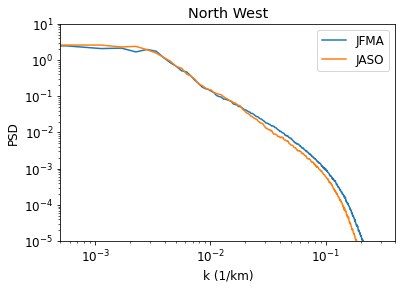

In [113]:
plt.plot(EKE_NW_k_ps.freq_i/dxNE.mean(),
         EKE_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(EKE_NW_k_ps.freq_i/dxNE.mean(),
         EKE_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-5, 10])
plt.legend()
plt.title('North West')

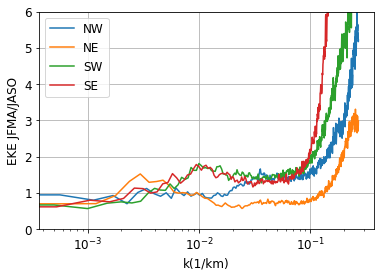

In [115]:
plt.plot(EKE_NW_k_ps.freq_i/dxNE.mean(),
         EKE_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         EKE_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='NW')
plt.plot(EKE_NE_k_ps.freq_i/dxNE.mean(),
         EKE_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         EKE_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='NE')
plt.plot(EKE_SW_k_ps.freq_i/dxSW.mean(),
         EKE_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         EKE_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='SW')
plt.plot(EKE_SE_k_ps.freq_i/dxSE.mean(),
         EKE_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month')/
         EKE_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
         label='SE')

plt.xscale('log')
plt.legend()
plt.ylim([0, 6])
plt.grid()
plt.xlabel('k(1/km)')
plt.ylabel('EKE JFMA/JASO')
plt.savefig('Ratio_EKE.png')

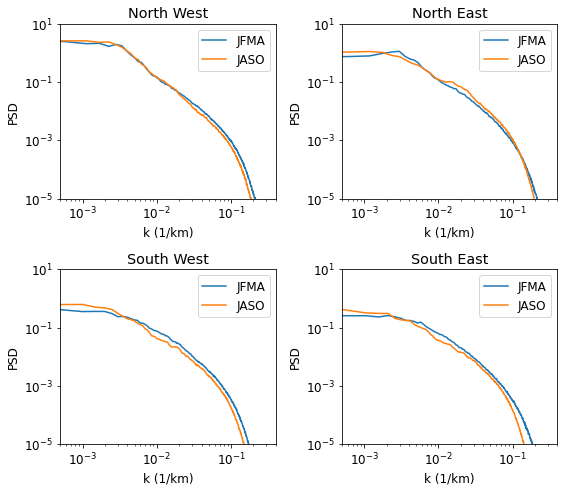

In [116]:
plt.figure(figsize=(8,7))
plt.subplot(221)
plt.plot(EKE_NW_k_ps.freq_i/dxNE.mean(),
         EKE_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(EKE_NW_k_ps.freq_i/dxNE.mean(),
         EKE_NW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-5, 10])
plt.legend()
plt.title('North West')

plt.subplot(222)
plt.plot(EKE_NE_k_ps.freq_i/dxNE.mean(),
         EKE_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(EKE_NE_k_ps.freq_i/dxNE.mean(),
         EKE_NE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-5, 10])
plt.legend()
plt.title('North East')


plt.subplot(223)
plt.plot(EKE_SW_k_ps.freq_i/dxSW.mean(),
         EKE_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(EKE_SW_k_ps.freq_i/dxSW.mean(),
         EKE_SW_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-5, 10])
plt.legend()
plt.title('South West')

plt.subplot(224)
plt.plot(EKE_SE_k_ps.freq_i/dxSE.mean(),
         EKE_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(1,4)).mean('month'),
                                    label='JFMA')


plt.plot(EKE_SE_k_ps.freq_i/dxSE.mean(),
         EKE_SE_k_ps.groupby("time.month").mean().mean('j').sel(month=slice(7,10)).mean('month'),
                                    label='JASO')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-5, 10])
plt.legend()
plt.title('South East')

plt.tight_layout()

plt.savefig('Spectra_KE.png')

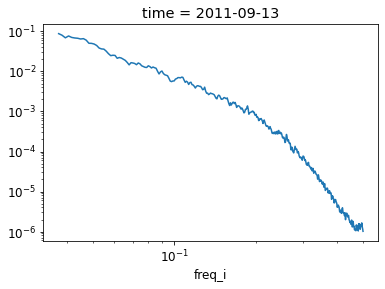

In [117]:
EKE_NE_k_ps.where(EKE_NE_k_ps.freq_i/dxNE.mean()>1/50,
                  drop=True).mean('j').isel(time=0).plot()
plt.xscale('log')
plt.yscale('log')

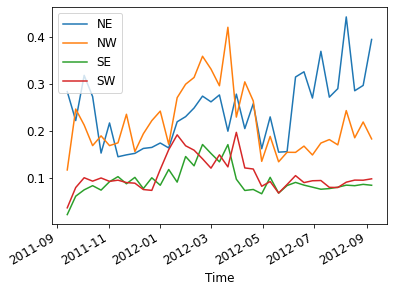

In [118]:
EKE_NE_k_ps.where(EKE_NE_k_ps.freq_i/dxNE.mean()>1/20,
                  drop=True).sum('freq_i').mean('j').plot(label='NE')
EKE_NW_k_ps.where(EKE_NW_k_ps.freq_i/dxNW.mean()>1/20,
                  drop=True).sum('freq_i').mean('j').plot(label='NW')
EKE_SE_k_ps.where(EKE_SE_k_ps.freq_i/dxSE.mean()>1/20,
                  drop=True).sum('freq_i').mean('j').plot(label='SE')
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/20,
                  drop=True).sum('freq_i').mean('j').plot(label='SW')
plt.legend()

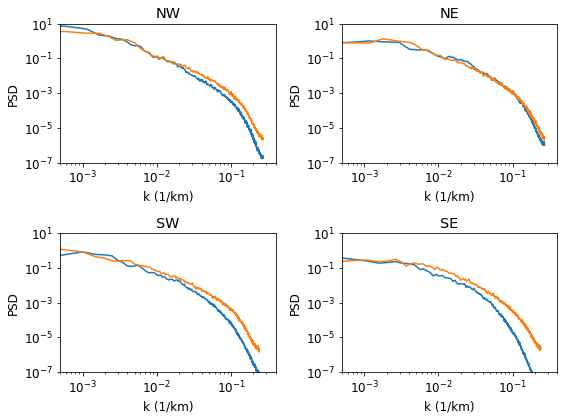

In [119]:
plt.figure(figsize=(8,6))
plt.subplot(222)
plt.plot(EKE_NE_k_ps.freq_i/dxNE.mean(),
         EKE_NE_k_ps.mean('j').isel(time=0))
plt.plot(EKE_NE_k_ps.freq_i/dxNE.mean(),
         EKE_NE_k_ps.mean('j').isel(time=18))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-7, 10])
plt.title('NE')

plt.subplot(221)
plt.plot(EKE_NW_k_ps.freq_i/dxNW.mean(),
         EKE_NW_k_ps.mean('j').isel(time=0))
plt.plot(EKE_NW_k_ps.freq_i/dxNW.mean(),
         EKE_NW_k_ps.mean('j').isel(time=18))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-7, 10])
plt.title('NW')

plt.subplot(224)
plt.plot(EKE_SE_k_ps.freq_i/dxSE.mean(),
         EKE_SE_k_ps.mean('j').isel(time=0))
plt.plot(EKE_SE_k_ps.freq_i/dxSE.mean(),
         EKE_SE_k_ps.mean('j').isel(time=18))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-7, 10])
plt.title('SE')

plt.subplot(223)
plt.plot(EKE_SW_k_ps.freq_i/dxSW.mean(),
         EKE_SW_k_ps.mean('j').isel(time=0))
plt.plot(EKE_SW_k_ps.freq_i/dxSW.mean(),
         EKE_SW_k_ps.mean('j').isel(time=18))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (1/km)')
plt.ylabel('PSD')
plt.xlim([5e-4, 4e-1])
plt.ylim([1e-7, 10])
plt.title('SW')

plt.tight_layout()

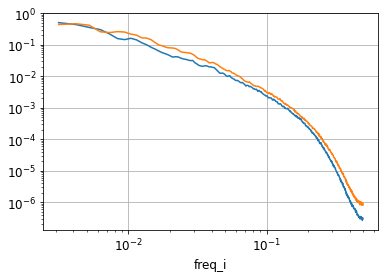

In [120]:
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=slice(0,8)).mean('time').plot()
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=slice(18,26)).mean('time').plot()
plt.xscale('log')
plt.yscale('log')
plt.grid()

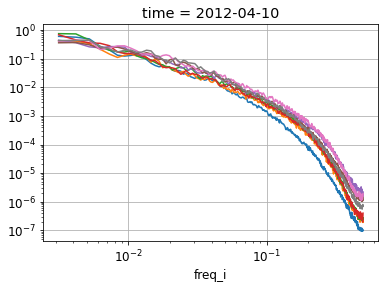

In [121]:
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=0).plot()
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=1).plot()
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=2).plot()
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=3).plot()

EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=18).plot()
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=19).plot()
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=20).plot()
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/1000,
                  drop=True).mean('j').isel(time=21).plot()

plt.xscale('log')
plt.yscale('log')
plt.grid()

In [123]:
EKE_NW_k_ps

<xarray.DataArray (time: 37, j: 64, freq_i: 960)>
array([[[5.11294646e-10, 1.60452688e-09, 8.25638805e-09, ...,
         8.49384782e-09, 8.25638805e-09, 1.60452688e-09],
        [3.25751129e-09, 5.54471036e-09, 1.59383068e-08, ...,
         8.83161821e-09, 1.59383068e-08, 5.54471036e-09],
        [1.71830152e-08, 1.81325760e-08, 1.83507047e-09, ...,
         1.66675523e-08, 1.83507047e-09, 1.81325760e-08],
        ...,
        [4.74950536e-07, 2.35158444e-07, 6.93697977e-08, ...,
         1.18845123e-07, 6.93697977e-08, 2.35158444e-07],
        [7.15258101e-07, 7.73640831e-07, 5.10366066e-07, ...,
         2.19761916e-07, 5.10366066e-07, 7.73640831e-07],
        [1.86250587e-08, 9.79273395e-08, 2.99977266e-07, ...,
         2.98932655e-07, 2.99977266e-07, 9.79273395e-08]],

       [[4.30132900e-08, 2.22785570e-09, 1.24398824e-07, ...,
         3.70741152e-08, 1.24398824e-07, 2.22785570e-09],
        [1.54729160e-07, 3.33891137e-08, 4.97714509e-08, ...,
         1.10247219e-07, 4.97714509e-08, 3.33891137e-08],
        [5.29175443e-07, 4.56344144e-07, 2.62663506e-07, ...,
         2.01601093e-07, 2.62663506e-07, 4.56344144e-07],
...
        [5.15545865e-07, 6.28778344e-07, 3.21044773e-07, ...,
         2.95565611e-07, 3.21044773e-07, 6.28778344e-07],
        [7.69523621e-07, 3.02829120e-07, 2.24986950e-07, ...,
         4.06691910e-07, 2.24986950e-07, 3.02829120e-07],
        [4.77373701e-08, 2.93816889e-07, 4.89437499e-07, ...,
         3.53683677e-07, 4.89437499e-07, 2.93816889e-07]],

       [[6.12397889e-11, 2.43383507e-08, 2.79963951e-08, ...,
         1.60846435e-08, 2.79963951e-08, 2.43383507e-08],
        [1.69126002e-07, 2.49343491e-07, 1.18017940e-07, ...,
         4.04075403e-08, 1.18017940e-07, 2.49343491e-07],
        [5.41218553e-08, 2.97107004e-08, 2.53848128e-08, ...,
         1.57589134e-08, 2.53848128e-08, 2.97107004e-08],
        ...,
        [7.75304295e-07, 3.25397907e-07, 3.97776114e-07, ...,
         3.20629617e-07, 3.97776114e-07, 3.25397907e-07],
        [7.42401415e-07, 3.36053654e-07, 4.28323440e-08, ...,
         1.11649364e-07, 4.28323440e-08, 3.36053654e-07],
        [1.05201479e-07, 1.32147353e-07, 1.66955362e-07, ...,
         1.26951763e-07, 1.66955362e-07, 1.32147353e-07]]])
Coordinates:
  * j        (j) int64 9627 9637 9647 9657 9667 ... 10227 10237 10247 10257
  * time     (time) datetime64[ns] 2011-09-13 2011-09-23 ... 2012-09-07
  * freq_i   (freq_i) float64 -0.5 -0.499 -0.4979 ... 0.4969 0.4979 0.499

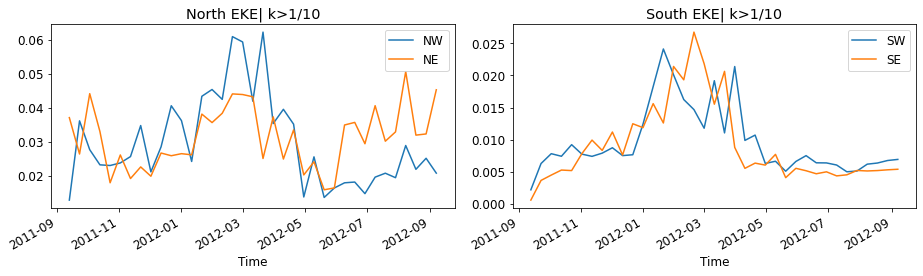

In [126]:
plt.figure(figsize=(13,4))

plt.subplot(121)
(EKE_NW_k_ps.where(EKE_NW_k_ps.freq_i/dxNW.mean()>1/10,
                  drop=True).sum('freq_i').mean('j')*(1)).plot(label='NW')

(EKE_NE_k_ps.where(EKE_NE_k_ps.freq_i/dxNW.mean()>1/10,
                  drop=True).sum('freq_i').mean('j')*(1)).plot(label='NE')
plt.legend()
plt.title('North EKE| k>1/10')

plt.subplot(122)
(EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/10,
                  drop=True).sum('freq_i').mean('j')*(1)).plot(label='SW')

(EKE_SE_k_ps.where(EKE_SE_k_ps.freq_i/dxSW.mean()>1/10,
                  drop=True).sum('freq_i').mean('j')*(1)).plot(label='SE')
plt.legend()
plt.title('South EKE| k>1/10')

plt.tight_layout()
plt.savefig('small_scale_eke.png')

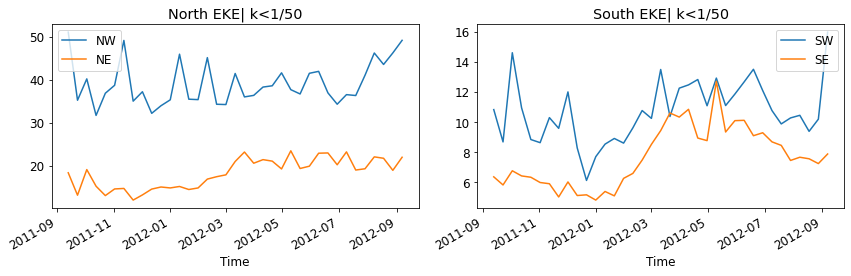

In [128]:
# EKE_NW_k_ps.freq_i_spacing
plt.figure(figsize=(12,4))

plt.subplot(121)
(EKE_NW_k_ps.where(EKE_NW_k_ps.freq_i/dxNW.mean()<1/50,
                  drop=True).sum('freq_i').mean('j')*(1)).plot(label='NW')

(EKE_NE_k_ps.where(EKE_NE_k_ps.freq_i/dxNW.mean()<1/50,
                  drop=True).sum('freq_i').mean('j')*(1)).plot(label='NE')
plt.legend()
plt.title('North EKE| k<1/50')

plt.subplot(122)
(EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()<1/50,
                  drop=True).sum('freq_i').mean('j')*(1)).plot(label='SW')

(EKE_SE_k_ps.where(EKE_SE_k_ps.freq_i/dxSW.mean()<1/50,
                  drop=True).sum('freq_i').mean('j')*(1)).plot(label='SE')
plt.legend()
plt.title('South EKE| k<1/50')

plt.tight_layout()
plt.savefig('large_scale_eke.png')



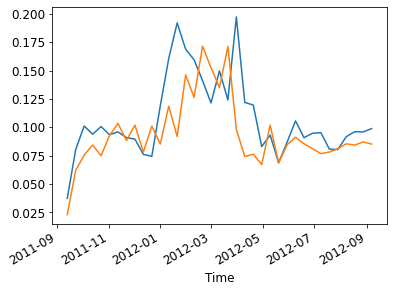

In [124]:
EKE_SW_k_ps.where(EKE_SW_k_ps.freq_i/dxSW.mean()>1/20,
                  drop=True).sum('freq_i').mean('j').plot(label='SW')

EKE_SE_k_ps.where(EKE_SE_k_ps.freq_i/dxSW.mean()>1/20,
                  drop=True).sum('freq_i').mean('j').plot(label='SE')

### Time series of variance in different bands

In [ ]:
# Maps of Vorticity
